In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

latent_dim = 100
n_classes = 10
img_shape = (1, 28, 28)
img_size = 28

lr = 0.0002
batch_size = 64
n_epochs = 50

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

mnist_dataset = datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    mnist_dataset,
    batch_size=batch_size,
    shuffle=True
)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.07MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(latent_dim + n_classes, 128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        embedded_labels = self.label_embedding(labels)
        gen_input = torch.cat((embedded_labels, noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        embedded_labels = self.label_embedding(labels)
        d_in = torch.cat((img_flat, embedded_labels), -1)
        validity = self.model(d_in)
        return validity


In [ ]:
adversarial_loss = torch.nn.BCELoss()

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

Starting Training Loop...
[Epoch 1/50] [D loss: 0.2196] [G loss: 1.6756]
[Epoch 2/50] [D loss: 0.2442] [G loss: 1.9764]
[Epoch 3/50] [D loss: 0.1767] [G loss: 1.8027]
[Epoch 4/50] [D loss: 0.4922] [G loss: 3.1505]
[Epoch 5/50] [D loss: 0.9301] [G loss: 4.1815]
[Epoch 6/50] [D loss: 0.3742] [G loss: 1.3196]
[Epoch 7/50] [D loss: 0.4718] [G loss: 0.7002]
[Epoch 8/50] [D loss: 0.4426] [G loss: 0.9204]
[Epoch 9/50] [D loss: 0.2162] [G loss: 1.9819]
[Epoch 10/50] [D loss: 0.4541] [G loss: 1.5638]
[Epoch 11/50] [D loss: 0.4258] [G loss: 2.0868]
[Epoch 12/50] [D loss: 0.5212] [G loss: 1.1727]
[Epoch 13/50] [D loss: 0.5481] [G loss: 0.9879]
[Epoch 14/50] [D loss: 0.5651] [G loss: 1.6110]
[Epoch 15/50] [D loss: 0.5557] [G loss: 1.5064]
[Epoch 16/50] [D loss: 0.5511] [G loss: 0.8308]
[Epoch 17/50] [D loss: 0.6173] [G loss: 0.9693]
[Epoch 18/50] [D loss: 0.5852] [G loss: 1.4038]
[Epoch 19/50] [D loss: 0.5229] [G loss: 1.0183]
[Epoch 20/50] [D loss: 0.5885] [G loss: 0.7862]
[Epoch 21/50] [D loss: 

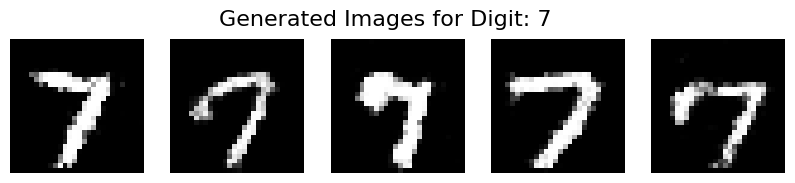

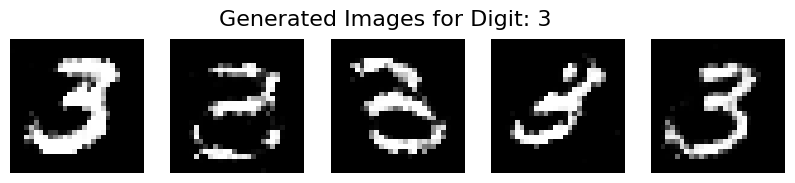

In [ ]:
print("Starting Training Loop...")
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        valid = torch.full((imgs.size(0), 1), 1.0, dtype=torch.float, device=device)
        fake = torch.full((imgs.size(0), 1), 0.0, dtype=torch.float, device=device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer_G.zero_grad()

        z = torch.randn(imgs.size(0), latent_dim, device=device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),), device=device)

        gen_imgs = generator(z, gen_labels)

        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()

        real_pred = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

    print(
        f"[Epoch {epoch+1}/{n_epochs}] [D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
    )

print("Training finished.")

def generate_digits(n_images, digit):
    """Generates and displays n_images of a specific digit."""
    generator.eval()

    z = torch.randn(n_images, latent_dim, device=device)
    labels = torch.full((n_images,), digit, dtype=torch.long, device=device)

    with torch.no_grad():
        generated_imgs = generator(z, labels).cpu()

    generated_imgs = 0.5 * generated_imgs + 0.5

    fig, axes = plt.subplots(1, n_images, figsize=(10, 2))
    fig.suptitle(f"Generated Images for Digit: {digit}", fontsize=16)
    for i, img_tensor in enumerate(generated_imgs):
        ax = axes[i]
        ax.imshow(img_tensor.squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

generate_digits(n_images=5, digit=7)

generate_digits(n_images=5, digit=3)




In [ ]:
torch.save(generator.state_dict(), 'generator_mnist.pth')
torch.save(discriminator.state_dict(), 'discriminator_mnist.pth')